In [9]:
import nltk
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [ ]:
nltk.download('punkt')
nltk.download('gutenberg')

In [3]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')

#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [8]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(
    max_df=0.5, #don't use words that occur in over half the paras
    min_df=2, #words have to occur atleast twice
    stop_words='english',
    lowercase=True, #converts all text to lowercase
    use_idf=True,
    norm=u'l2',
    smooth_idf=True #adds 1 to all df's so that divide by zero errors are solved
)

emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('Number of Features: {}'.format(emma_paras_tfidf.get_shape()[0]))

X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paras
n = X_train_tfidf_csr.shape[0]

#list of dictionaries, 1 for each para
tfidf_bypara = [{} for _ in range(0,n)]

terms = vectorizer.get_feature_names()

for i,j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of Features: 2371
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [11]:
#telling the data reducer how many features to reduce to
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

#run SVD on training data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)

paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print('{}\n'.format(paras_by_component.loc[:, i].sort_values(ascending=False)[:10]))

Percent variance captured by all components: 45.1944968503749
Component 0:
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !"    0.99929
" Oh !"    0.99929
" Oh !     0.99929
" Oh !     0.99929
" Oh !     0.99929
Name: 0, dtype: float64

Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633987
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.580307
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.564880
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it 

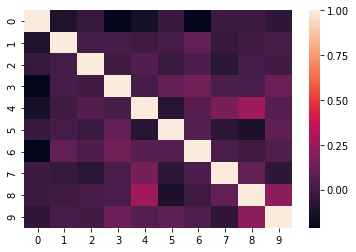

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [12]:
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10, 0:10]

ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

Drill 0: Test set

Apply the LSA model to the test set. Does it indentify similar sentences for components 0-4?

In [15]:
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of paras
n = X_test_tfidf_csr.shape[0]

#list of dictionaries, 1 for each para
tfidf_bypara = [{} for _ in range(0,n)]

terms = vectorizer.get_feature_names()

for i,j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i, j]
    
print('Original sentence:', X_test[5])
print('Tf_idf vector:', tfidf_bypara[5])

#telling the data reducer how many features to reduce to
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

#run SVD on training data
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)

paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print('{}\n'.format(paras_by_component.loc[:, i].sort_values(ascending=False)[:10]))

Original sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector: {'resolving': 0.3424390305045805, 'unexceptionable': 0.3196409792117937, 'assure': 0.267729777836069, 'friends': 0.2515333740641343, 'quite': 0.1916471918420347, 'replied': 0.20315405638674577, 'watch': 0.62300800500314, 'elton': 0.16874782424809767, 'pass': 0.28445227585106625, 'really': 0.21963852817625326, 'mrs': 0.14780961753993585}
Percent variance captured by all components: 49.39131221416925
Component 0:
" Oh !       0.999921
" Oh !       0.999921
" Oh !       0.999921
" Oh !"      0.999921
" Oh !       0.999921
" Oh !       0.999921
" Oh !       0.999921
" Oh !       0.999921
" Oh !       0.999921
" Oh no !    0.999921
Name: 0, dtype: float64

Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you s

The test set identifies some of the components the same as the training data. Component 0 is still the exclamation "OH!". The "AHs!" are still there own component, but this test data did not break out the chapter headers as their own component. Component 4 is made up of sentences that are agreeing to something or answering in the affirmative.

Drill 1: Tweaking tf-idf

Go back to the vectorizer and alter decision points or add in spacy information to see the resulting outcome changes of the LSA.

In [17]:
vectorizer = TfidfVectorizer(
    max_df=0.33, #don't use words that occur in over half the paras
    min_df=10, #words have to occur atleast twice
    #stop_words='english',
    lowercase=True, #converts all text to lowercase
    use_idf=True,
    norm=u'l2',
    smooth_idf=True #adds 1 to all df's so that divide by zero errors are solved
)

emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print('Number of Features: {}'.format(emma_paras_tfidf.get_shape()[0]))

X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paras
n = X_train_tfidf_csr.shape[0]

#list of dictionaries, 1 for each para
tfidf_bypara = [{} for _ in range(0,n)]

terms = vectorizer.get_feature_names()

for i,j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]
    
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

#telling the data reducer how many features to reduce to
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

#run SVD on training data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)

paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print('{}\n'.format(paras_by_component.loc[:, i].sort_values(ascending=False)[:10]))

Number of Features: 2371
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.4826081283404719, 'present': 0.47494198938659093, 'however': 0.4326309926721013, 'more': 0.3336482844036436, 'few': 0.4283085365221508, 'very': 0.24409126410735174}
Percent variance captured by all components: 66.25815106663875
Component 0:
Mrs . Weston was acting no part , feigning no feelings in all that she said to him in favour of the event . She had been extremely surprized , never more so , than when Emma first opened the affair to her ; but she saw in it only increase of happiness to all , and had no scruple in urging him to the utmost . She had such a regard for Mr . Knightley , as to think he deserved even her dearest Emma ; and it was in every respect so proper , suitable , and unexceptionable a connexion , and in one respect , one point of the highest importance , so peculiarly eligible , so singularly fortunate , that now it seemed as if

Leaving the stop words in the model created a component that has some extremely long sentences. Component 0, is made up of extremely long sentences with lots of punctuation and stop words. It still captures the "OH!" component and the "Chapter component". It also has ended up with components that are not very meaningful. Component 4 is made up of descriptive sentences, but could be from a number of texts.